# Module 3 Assignment: MNIST Classification

Now that we have the full power of PyTorch at our disposal, we would like to classify a more concrete dataset. In particular, we are going to look at building a classifier for the [MNIST Handwritten Digits dataset](https://en.wikipedia.org/wiki/MNIST_database). This dataset contains tens of thousands of handwritten digits from 0-9 and is very commonly used for machine learning algorithm development. In this assignment, we will provide some basic dataloading code and would like you to build a deep neural network that is trained on the MNIST dataset! Feel free to reuse code you have written or seen before in previous notebooks!

In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import time, copy
# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

First we will load in our MNIST dataset. Pytorch provides built in functions for loading popular image datasets, MNIST is one of them.

In [ ]:
# These transforms will be performed on every datapoint - in this example we want to transform every
# datapoint to a Tensor datatype, and perform
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
mnist_train = torchvision.datasets.MNIST('', train=True, transform =transform, download=True)
# We will split out train dataset into train and validation!
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])
mnist_test = torchvision.datasets.MNIST('', train=False, transform = transform, download=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15549012.40it/s]


Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 535787.65it/s]


Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4401953.41it/s]


Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7167241.82it/s]


Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



In [ ]:
# We will create DataLoaders just like before with a batch size of 100
batch_size = 100
dataloaders = {'train': DataLoader(mnist_train, batch_size=batch_size),
               'val': DataLoader(mnist_val, batch_size=batch_size),
               'test': DataLoader(mnist_test, batch_size=batch_size)}

dataset_sizes = {'train': len(mnist_train),
                 'val': len(mnist_val),
                 'test': len(mnist_test)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 50000, 'val': 10000, 'test': 10000}


In [ ]:
# Hint! In the Module 3 Introduction to Pytorch notebook, the Network
# we created required the input data to be of shape Nx1 where N is the number of
# features. Currently, our MNIST dataset is shape 28x28 as they are images. Use
# this code snippet as you iterate through the datapoint in your dataset to flatten
# them so it is size 784x1 and can be used with the models we designed previously!

# This loop only iterates through the "train" datapoints
# In the previous notebook
phases = ["train", "val", "test"]
for phase in phases:
  for inputs, labels in dataloaders[phase]:
    # This flattens every every batch to the correct size!
    inputs = inputs.view(inputs.shape[0],-1)
    inputs = inputs.to(device)
    labels = labels.to(device)

In [ ]:
# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
# hyperparameters

# model architecture
input_size = 784 # Make sure to remove the index column
hidden_size1 = 64
hidden_size2 = 64
hidden_size3 = 64
num_classes = 10

# external training parameters
batch_size = 64
learning_rate = 0.001
num_epochs = 50


In [ ]:
class ThreeLayerClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes):
        super(ThreeLayerClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            nn.Linear(hidden_size3, num_classes),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
three_layer_model = ThreeLayerClassifier(input_size, hidden_size1, hidden_size2, hidden_size3, num_classes).to(device)
print(three_layer_model)

ThreeLayerClassifier(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [ ]:
def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # keep the best weights stored separately
    best_acc = 0.0
    best_epoch = 0

    phases = ['train', 'val', 'test']

    # Keep track of how loss and accuracy evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # This ensures all of our datapoints are flattened
                # before feeding them to our model
                inputs = inputs.view(inputs.shape[0],-1)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + update weights only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model if it's the best accuracy (based on validation)
            if phase == 'val' and epoch_acc > best_acc:
                best_epoch = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, training_curves

In [ ]:
# Three-hidden-Layer Training
# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(three_layer_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model. We also will store the results of training to visualize
three_layer_model, training_curves_three_layer = train_model(three_layer_model, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/50
----------
train Loss: 0.5431 Acc: 0.8371
val   Loss: 0.3163 Acc: 0.9098
test  Loss: 0.3066 Acc: 0.9135

Epoch 2/50
----------
train Loss: 0.2724 Acc: 0.9184
val   Loss: 0.2262 Acc: 0.9335
test  Loss: 0.2189 Acc: 0.9355

Epoch 3/50
----------
train Loss: 0.2060 Acc: 0.9361
val   Loss: 0.1852 Acc: 0.9443
test  Loss: 0.1809 Acc: 0.9431

Epoch 4/50
----------
train Loss: 0.1650 Acc: 0.9500
val   Loss: 0.1622 Acc: 0.9497
test  Loss: 0.1605 Acc: 0.9490

Epoch 5/50
----------
train Loss: 0.1386 Acc: 0.9576
val   Loss: 0.1497 Acc: 0.9532
test  Loss: 0.1491 Acc: 0.9521

Epoch 6/50
----------
train Loss: 0.1196 Acc: 0.9633
val   Loss: 0.1314 Acc: 0.9597
test  Loss: 0.1316 Acc: 0.9588

Epoch 7/50
----------
train Loss: 0.1060 Acc: 0.9680
val   Loss: 0.1196 Acc: 0.9635
test  Loss: 0.1194 Acc: 0.9639

Epoch 8/50
----------
train Loss: 0.0950 Acc: 0.9712
val   Loss: 0.1158 Acc: 0.9651
test  Loss: 0.1150 Acc: 0.9656

Epoch 9/50
----------
train Loss: 0.0860 Acc: 0.9736
val   Loss: 0.1163

In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(training_curves,
                         phases=['train', 'val', 'test'],
                         metrics=['loss', 'acc']):
    # Determine the number of epochs from one of the metrics, assumes all are the same length
    epochs = list(range(len(training_curves['train_' + metrics[0]])))

    for metric in metrics:
        plt.figure()
        plt.title(f'Training Curves - {metric.capitalize()}')
        for phase in phases:
            key = phase + '_' + metric
            if key in training_curves:
                # Convert tensor to CPU if it is not already
                data = training_curves[key]
                if isinstance(data[0], torch.Tensor):  # Check if the data is in tensor format
                    data = [x.cpu().numpy() if x.is_cuda else x.numpy() for x in data]  # Convert tensors to numpy arrays
                plt.plot(epochs, data, label=phase)
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)
        plt.show()


def classify_predictions(model, device, dataloader):
    model.eval()   # Set model to evaluate mode
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, labels in dataloader:
        # Important! We need to flatten every datapoint
        inputs = inputs.view(inputs.shape[0], -1)
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs),dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:,1]
        all_labels = torch.cat((all_labels, labels), 0)
        all_scores = torch.cat((all_scores, scores), 0)
        all_preds = torch.cat((all_preds, preds), 0)
    return all_preds.detach().cpu(), all_labels.detach().cpu(), all_scores.detach().cpu()

def plot_cm(model, device, dataloaders, phase='test'):
    class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])

    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')


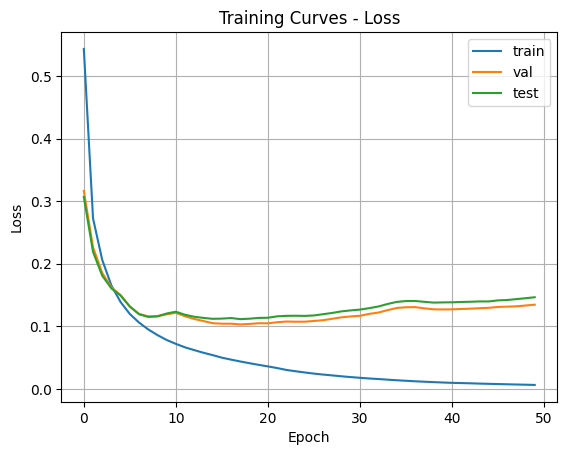

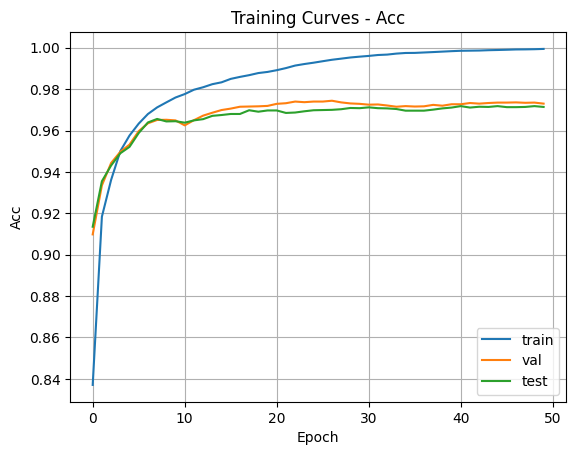

In [ ]:
plot_training_curves(training_curves_three_layer, phases=['train', 'val', 'test'])

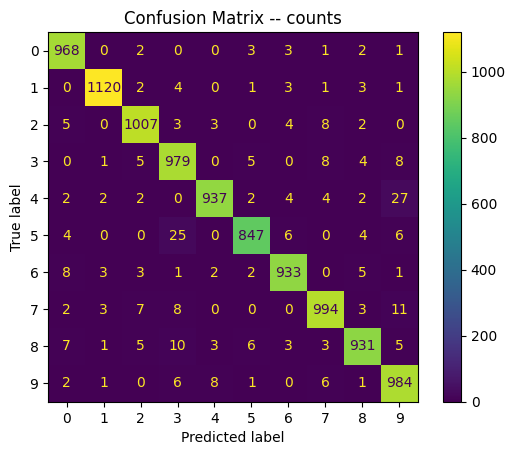

In [ ]:
res = plot_cm(three_layer_model, device, dataloaders, phase='test')

# now adding dropout

In [ ]:
# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
# hyperparameters

# model architecture
input_size = 784 # Make sure to remove the index column
hidden_size1 = 64
hidden_size2 = 64
hidden_size3 = 64
num_classes = 10
dropout = .25
# external training parameters
batch_size = 64
learning_rate = 0.001
num_epochs = 30



In [ ]:
class ThreeLayerClassifierWDropout(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes, dropout):
        super(ThreeLayerClassifierWDropout, self).__init__()
        self.dropout = nn.Dropout(dropout) # dropout rate
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_size3, num_classes),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
three_layer_model_w_dropout = ThreeLayerClassifierWDropout(input_size, hidden_size1, hidden_size2, hidden_size3, num_classes, dropout).to(device)
print(three_layer_model_w_dropout)


ThreeLayerClassifierWDropout(
  (dropout): Dropout(p=0.25, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [ ]:
# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(three_layer_model_w_dropout.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model. We also will store the results of training to visualize
three_layer_model_w_dropout, training_curves_three_layer_w_dropout = train_model(three_layer_model_w_dropout, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/30
----------
train Loss: 0.7768 Acc: 0.7458
val   Loss: 0.3183 Acc: 0.9077
test  Loss: 0.2987 Acc: 0.9131

Epoch 2/30
----------
train Loss: 0.4152 Acc: 0.8772
val   Loss: 0.2550 Acc: 0.9221
test  Loss: 0.2391 Acc: 0.9274

Epoch 3/30
----------
train Loss: 0.3527 Acc: 0.8941
val   Loss: 0.2083 Acc: 0.9391
test  Loss: 0.1978 Acc: 0.9397

Epoch 4/30
----------
train Loss: 0.3221 Acc: 0.9055
val   Loss: 0.2020 Acc: 0.9393
test  Loss: 0.1868 Acc: 0.9448

Epoch 5/30
----------
train Loss: 0.2964 Acc: 0.9138
val   Loss: 0.1834 Acc: 0.9474
test  Loss: 0.1741 Acc: 0.9463

Epoch 6/30
----------
train Loss: 0.2816 Acc: 0.9185
val   Loss: 0.1795 Acc: 0.9458
test  Loss: 0.1699 Acc: 0.9494

Epoch 7/30
----------
train Loss: 0.2683 Acc: 0.9221
val   Loss: 0.1750 Acc: 0.9512
test  Loss: 0.1662 Acc: 0.9477

Epoch 8/30
----------
train Loss: 0.2544 Acc: 0.9240
val   Loss: 0.1665 Acc: 0.9507
test  Loss: 0.1612 Acc: 0.9503

Epoch 9/30
----------
train Loss: 0.2512 Acc: 0.9272
val   Loss: 0.1565

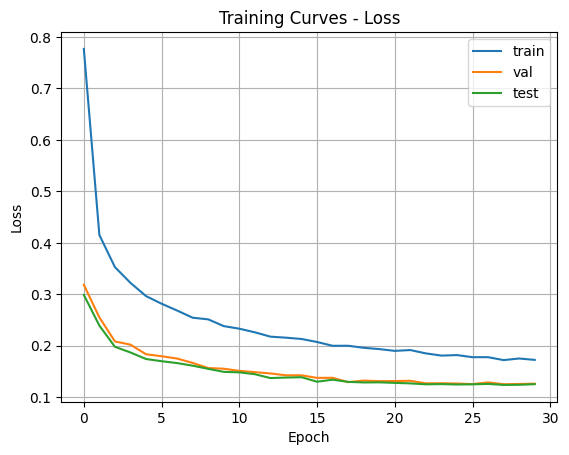

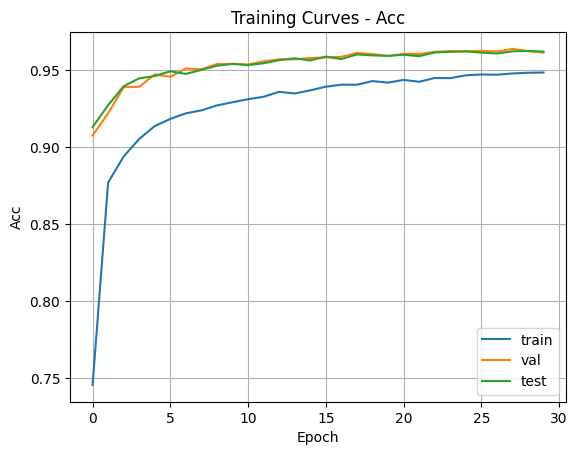

In [ ]:
plot_training_curves(training_curves_three_layer_w_dropout, phases=['train', 'val', 'test'])

# Regularization

In [ ]:
three_layer_model_w_reg = ThreeLayerClassifier(input_size, hidden_size1, hidden_size2, hidden_size3, num_classes).to(device)
print(three_layer_model_w_reg)

ThreeLayerClassifier(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [ ]:
# Three-hidden-Layer Training
# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(three_layer_model_w_reg.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model. We also will store the results of training to visualize
three_layer_model_w_reg, training_curves_three_layer_w_reg = train_model(three_layer_model_w_reg, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=30)


Epoch 1/30
----------
train Loss: 0.5694 Acc: 0.8305
val   Loss: 0.3589 Acc: 0.8996
test  Loss: 0.3472 Acc: 0.8997

Epoch 2/30
----------
train Loss: 0.3220 Acc: 0.9058
val   Loss: 0.2986 Acc: 0.9177
test  Loss: 0.2888 Acc: 0.9162

Epoch 3/30
----------
train Loss: 0.2734 Acc: 0.9216
val   Loss: 0.2691 Acc: 0.9244
test  Loss: 0.2580 Acc: 0.9226

Epoch 4/30
----------
train Loss: 0.2458 Acc: 0.9292
val   Loss: 0.2443 Acc: 0.9312
test  Loss: 0.2332 Acc: 0.9322

Epoch 5/30
----------
train Loss: 0.2293 Acc: 0.9342
val   Loss: 0.2291 Acc: 0.9369
test  Loss: 0.2191 Acc: 0.9369

Epoch 6/30
----------
train Loss: 0.2182 Acc: 0.9377
val   Loss: 0.2186 Acc: 0.9403
test  Loss: 0.2094 Acc: 0.9404

Epoch 7/30
----------
train Loss: 0.2090 Acc: 0.9408
val   Loss: 0.2125 Acc: 0.9421
test  Loss: 0.2035 Acc: 0.9424

Epoch 8/30
----------
train Loss: 0.2031 Acc: 0.9433
val   Loss: 0.2074 Acc: 0.9435
test  Loss: 0.1977 Acc: 0.9431

Epoch 9/30
----------
train Loss: 0.1968 Acc: 0.9455
val   Loss: 0.2036

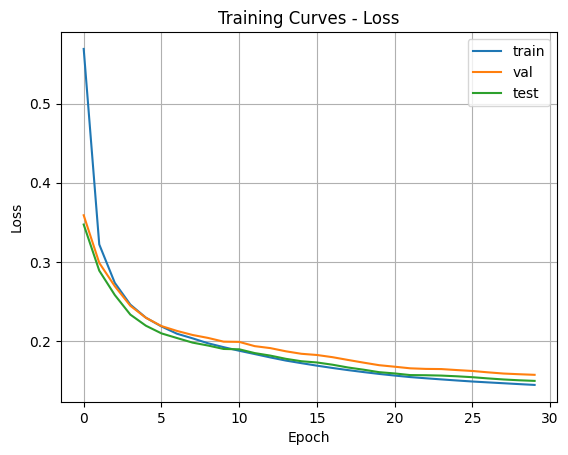

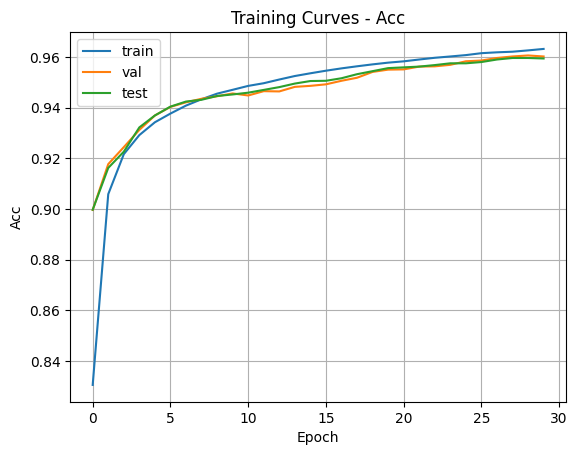

In [ ]:
plot_training_curves(training_curves_three_layer_w_reg, phases=['train', 'val', 'test'])